In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
from matplotlib.gridspec import GridSpec
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from connectivity.curves import CURVES


%load_ext autoreload
%autoreload 2
%aimport connectivity

base_path = "D:/data_paper"
patient_id = "EL027"
CLEAN_DATA_FILE = "out/clean_CR_IO/bad_responses_dict.json"
n_replications = 12
POWER_ANALYSIS_RESULT_FILE = "../publish_data/paper/power_analysis/power_analysis_lf.json" # ""../publish_data/curve_fitting/curve_fitting.json"
RESPONSES_FILE = "../publish_data/paper/significant_responses/response_channels_lf.json" # "../publish_data/significant_responses/response_channels_lf.json"
CURVE_FITTING_FILE = "../publish_data/paper/curve_fitting/curve_fitting_lf.json" # "../publish_data/significant_responses/response_channels_lf.json"
OUT_PATH = "../publish_data/paper/power_analysis"

INCLUDE_REPLICATIONS_LIST = [12, 9, 6, 5, 4, 3, 2, 1]
allowed_ids = ["EL019", "EL020", "EL021", "EL022", "EL026", "EL027", "EL028"]


EXCLUDE_INTENSITIES_MATRICES = {
        17: [
            [],  # all intensities
            [1],
            [1, 3],
            [1, 3, 5],
            [1, 3, 5, 7],
            [1, 3, 5, 7, 12],
            [1, 3, 5, 7, 12, 14],
            [1, 3, 5, 7, 12, 14, 10],
            [1, 3, 5, 7, 12, 14, 10, 8],
            [1, 3, 5, 7, 12, 14, 10, 15],
            [1, 3, 5, 7, 12, 14, 10, 8, 15],
        ],
        18: [
            [],  # all intensities
            [2],
            [2, 1],
            [2, 1, 4],
            [2, 1, 4, 6],
            [2, 1, 4, 6, 8],
            [2, 1, 4, 6, 8, 13],
            [2, 1, 4, 6, 8, 13, 15],
            [2, 1, 4, 6, 8, 13, 15, 11],
            [2, 1, 4, 6, 8, 13, 15, 11, 9],
            [2, 1, 4, 6, 8, 13, 15, 11, 16],
            [2, 1, 4, 6, 8, 13, 15, 11, 9, 16],
        ],
    }
intensities = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0])
norm_intensities = intensities / np.max(intensities)

CURVE = CURVES["5P"]


EFFECT_SIZE = 0.1
USE_MIN_NORMALIZATION = True
MAX_ITERATIONS = 1000
EFFECT_SIZE_PRECISION = 0.001
N_REPLICATIONS_ORIGINAL = 12
N_SURROGATES = 500
SIGNIFICANCE_LEVEL = 0.05
R_SQUARED_THRESHOLD = 0.6

In [2]:
power_analysis_df = pd.read_json(POWER_ANALYSIS_RESULT_FILE, orient="records")
power_analysis_df = power_analysis_df[(power_analysis_df["effect_size"] == EFFECT_SIZE)]
power_analysis_df = power_analysis_df[power_analysis_df["patient_id"].isin(allowed_ids)]
responses_df = pd.read_json(RESPONSES_FILE, orient="records")
responses_df = responses_df[responses_df["patient_id"].isin(allowed_ids)]

curve_fitting_df = pd.read_json(CURVE_FITTING_FILE, orient="records")
curve_fitting_df = curve_fitting_df[curve_fitting_df["patient_id"].isin(allowed_ids)]
responses_df = responses_df.drop(['2P_r_squared',
       '2P_params', '2P_d_aic', '3P_r_squared', '3P_params',
       '3P_d_aic', '4P_r_squared', '4P_params', '4P_d_aic',
       '5P_r_squared', '5P_params', '5P_d_aic', '6P_r_squared',
       '6P_params'], axis=1)


responses_df = pd.merge(
    responses_df,
    curve_fitting_df,
    on=["patient_id", "stim_channel_name", "response_channel_name"],
    how="left"
)
responses_df = responses_df[(responses_df["5P_r_squared"] > R_SQUARED_THRESHOLD) & (responses_df["is_significant"] == True)]

print(len(responses_df))

power_analysis_df = (
    power_analysis_df.groupby(["patient_id", "stim_channel_name", "response_channel_name", "effect_size"], as_index=False)
      .head(1)
)
power_analysis_df = pd.merge(
    responses_df,
    power_analysis_df,
    on=["patient_id", "stim_channel_name", "response_channel_name"],
    how="left"
)


761


### Power analysis

c:\Users\E1024679\Documents\coherence\connectivity\curves.py:9: RuntimeWarning: overflow encountered in power
  denominator = (base) ** (1 / shape)


(54, 12, 8)


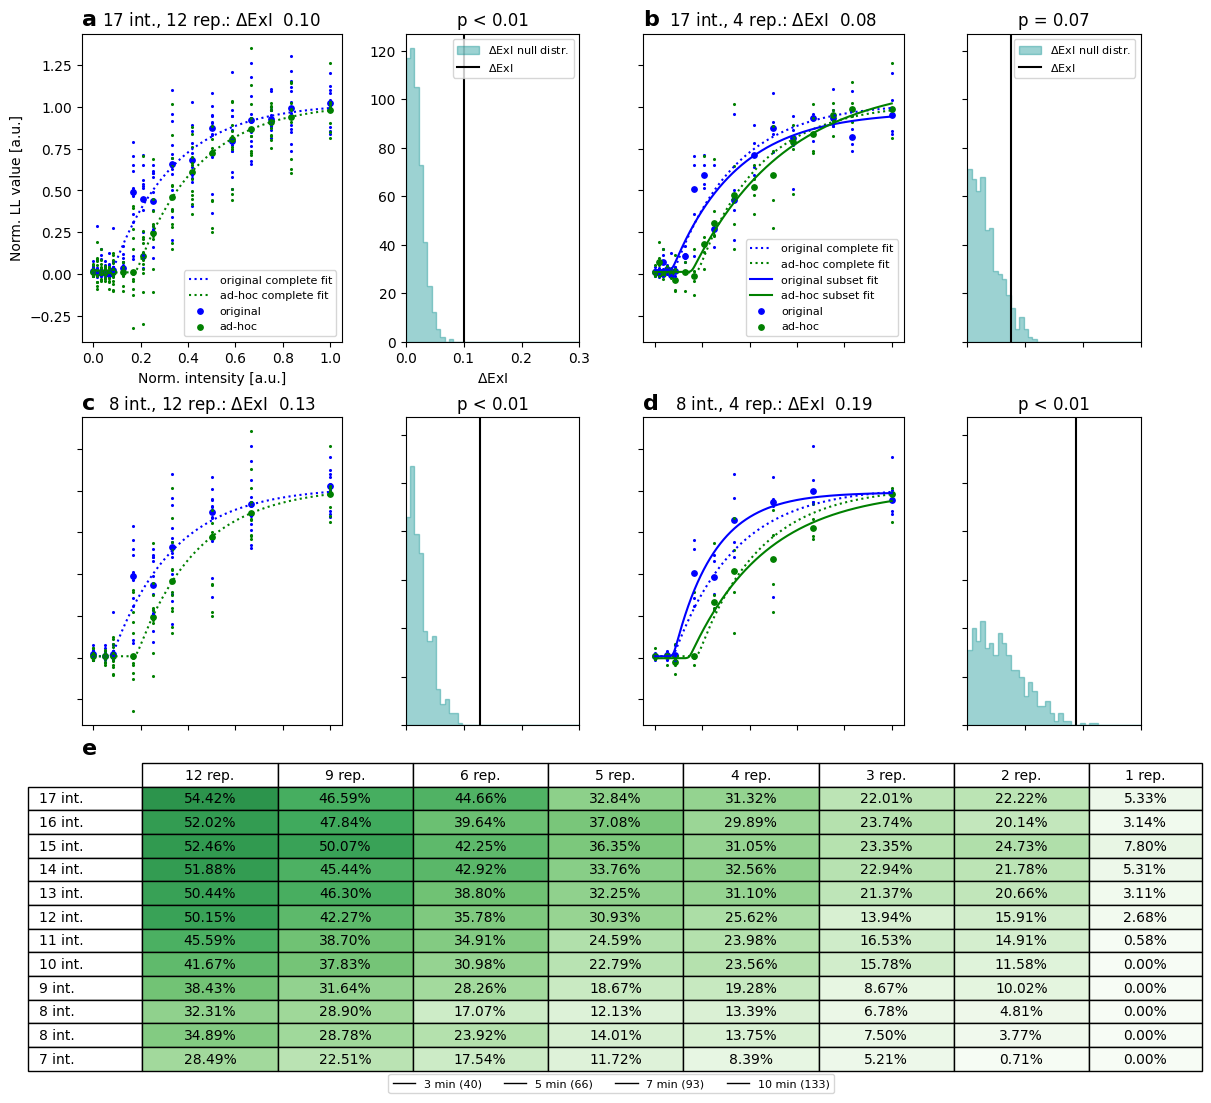

In [3]:
from connectivity.analyze import find_params_for_given_effect_size, fit_curve, normalize_ll_values, pick_random_replications, significant_exi_difference_testing
from matplotlib.lines import Line2D

from connectivity.load import parsed_list_to_numpy_array

def format_p(p):
    return "p < 0.01" if p < 0.01 else f"p = {p:.2f}"

np.random.seed(42)

patient_id = "EL027"
stim_channel_name_pos = "A-L-3"
stim_channel_name_neg = "A-L-4"
stim_channel_name = stim_channel_name_pos + "-" + stim_channel_name_neg

response_channel_name_pos = "aH-L-3"
response_channel_name_neg = "aH-L-4"
response_channel_name = response_channel_name_pos + "-" + response_channel_name_neg

pat_row = responses_df[
    (responses_df["patient_id"] == patient_id)
    & (responses_df["stim_channel_name"] == stim_channel_name)
    & (responses_df["response_channel_name"] == response_channel_name)
].squeeze()

original_lls = parsed_list_to_numpy_array(
    pat_row["ll_values"]
)  # shape: (n_intensities, n_replications)
original_med_lls = np.nanmedian(original_lls, axis=1)
original_norm_med_lls = normalize_ll_values(
    original_med_lls, axis=0, use_min=USE_MIN_NORMALIZATION
)
shared_original_ll_max = np.nanpercentile(
    original_med_lls, 95, axis=0
)
shared_original_ll_min = np.nanmin(original_med_lls, axis=0)
original_norm_lls = normalize_ll_values(
    original_lls,
    max=shared_original_ll_max,
    min=shared_original_ll_min,
    use_min=USE_MIN_NORMALIZATION,
    axis=0,
)
x_fit = np.linspace(0, 1, 1000)
# get original ExI
try:
    original_params = fit_curve(
        curve_function=CURVE["function"],
        x=norm_intensities,
        y=original_norm_med_lls,
        initial_values=CURVE["initial_values"],
        bounds=CURVE["bounds"],
        max_iterations=MAX_ITERATIONS,
    )

    original_y_fit = CURVE["function"](x_fit, *original_params)
    original_y_pred = CURVE["function"](
        norm_intensities, *original_params
    )

    original_exi = np.trapezoid(original_y_fit, x_fit)
except RuntimeError as e:
    print(
        f"{patient_id}: {stim_channel_name}/{response_channel_name}: Optimization failed."
    )

if original_params[2] < 0.3:
    _target_exi = original_exi - EFFECT_SIZE
else:
    _target_exi = original_exi + EFFECT_SIZE

new_params = find_params_for_given_effect_size(
    curve=CURVE,
    orig_params=original_params,
    selected_param_index=2,
    target_exi=_target_exi,
    x=x_fit,
    precision=EFFECT_SIZE_PRECISION,
)
new_y_fit = CURVE["function"](x_fit, *new_params)
# generate new datapoints

original_y_pred = CURVE["function"](
    norm_intensities, *original_params
)
new_y_pred = CURVE["function"](norm_intensities, *new_params)
new_norm_lls = []
for i_int, _ in enumerate(norm_intensities):
    residuals = original_norm_lls[i_int] - original_y_pred[i_int]
    target_std = np.std(residuals)
    generated_lls = np.random.normal(
        loc=0,
        scale=1,
        size=N_REPLICATIONS_ORIGINAL,
    )
    b = target_std / np.std(generated_lls)
    # new_y_pred[i_int] == target median
    a = new_y_pred[i_int] - b * np.median(generated_lls)
    generated_lls = a + b * generated_lls

    new_norm_lls.append(generated_lls)
new_norm_lls = np.array(new_norm_lls)

norm_intensities = intensities / np.max(
    intensities
)  # FIXME: for older patients than EL019complete_result[patient_id][stim_channel_name]["norm_intensities"]

norm_ll_values = pat_row["norm_med_lls"]

exclude_intensities_matrix = EXCLUDE_INTENSITIES_MATRICES.get(
    len(norm_intensities), None
)

def plot_cell(ax_l, ax_r, reduced_intensity, reduced_replication):
    # calculate surr
    int_reduced_intensities = np.delete(
        norm_intensities, exclude_intensities_matrix[reduced_intensity]
    )
    # ORIGINAL
    int_reduced_original_norm_lls = np.delete(
        original_norm_lls, exclude_intensities_matrix[reduced_intensity], axis=0
    )
    int_reduced_new_norm_lls = np.delete(
        new_norm_lls, exclude_intensities_matrix[reduced_intensity], axis=0
    )

    original_subset_lls = pick_random_replications(
        int_reduced_original_norm_lls,
        n_replications_to_select=INCLUDE_REPLICATIONS_LIST[reduced_replication],
    )
    original_subset_med_lls = np.nanmedian(
        original_subset_lls, axis=1
    )
    new_subset_lls = pick_random_replications(
        int_reduced_new_norm_lls,
        n_replications_to_select=INCLUDE_REPLICATIONS_LIST[reduced_replication],
    )
    new_subset_med_lls = np.nanmedian(new_subset_lls, axis=1)

    surr_p_value_empirical, surr_p_value = (
        significant_exi_difference_testing(
            norm_ll_values_1=original_subset_lls,
            norm_ll_values_2=new_subset_lls,
            n_surrogates=N_SURROGATES,
            intensities=int_reduced_intensities,
            curve=CURVE,
            ax=ax_r,
            parallelize=False,
        )
    )
    # FIT CURVES - note that we now fit the subset curve twice. This could be improved
    try:
        original_subset_params = fit_curve(
            curve_function=CURVE["function"],
            x=int_reduced_intensities,
            y=original_subset_med_lls,
            initial_values=CURVE["initial_values"],
            bounds=CURVE["bounds"],
            max_iterations=MAX_ITERATIONS,
        )
        original_subset_y_fit = CURVE["function"](
            x_fit, *original_subset_params
        )
        original_subset_exi = np.trapezoid(
            original_subset_y_fit, x_fit
        )
        original_subset_y_pred = CURVE["function"](
            int_reduced_intensities, *original_subset_params
        )
        new_subset_params = fit_curve(
            curve_function=CURVE["function"],
            x=int_reduced_intensities,
            y=new_subset_med_lls,
            initial_values=CURVE["initial_values"],
            bounds=CURVE["bounds"],
            max_iterations=MAX_ITERATIONS,
        )
        new_subset_y_fit = CURVE["function"](
            x_fit, *new_subset_params
        )
        new_subset_y_pred = CURVE["function"](
            int_reduced_intensities, *new_subset_params
        )
        new_subset_exi = np.trapezoid(new_subset_y_fit, x_fit)

        ax_l.plot(
            x_fit,
            original_y_fit,
            color="blue",
            label="original complete fit",
            linestyle=":",
        )
        ax_l.plot(
            x_fit,
            new_y_fit,
            color="green",
            label="ad-hoc complete fit",
            linestyle=":",
        )
        if reduced_replication != 0:
            ax_l.plot(
                x_fit,
                original_subset_y_fit,
                color="blue",
                label="original subset fit" if reduced_replication != 0 else "_nolegend_",
            )
            ax_l.plot(
                x_fit,
                new_subset_y_fit,
                color="green",
                label="ad-hoc subset fit" if reduced_replication != 0 else "_nolegend_",
            )
            
        
    except:
        pass
    ax_r.set_title(f"{format_p(surr_p_value)}")
    # left
    ax_l.scatter(
        int_reduced_intensities,
        original_subset_med_lls,
        color="blue",
        label="original",
        s=15
    )
    ax_l.scatter(
        int_reduced_intensities,
        new_subset_med_lls,
        color="green",
        label="ad-hoc",
        s=15
    )
    for src in original_subset_lls.T:
        ax_l.scatter(
            int_reduced_intensities,
            src,
            color="blue",
            label="_nolegend_",
            s=1.5,
        )
    for src in new_subset_lls.T:
        ax_l.scatter(
            int_reduced_intensities,
            src,
            color="green",
            label="_nolegend_",
            s=1.5,
        )
    ax_l.set_title(
        f"{len(int_reduced_intensities) -1} int., {INCLUDE_REPLICATIONS_LIST[reduced_replication]} rep.: $\\Delta$ExI {np.abs(new_subset_exi - original_subset_exi): .2f}"
    )


def fdr_axis0_ignore_nan(pvals, method="bh"):
    """Apply FDR correction along axis=0, ignoring NaNs."""
    out = np.full_like(pvals, np.nan, dtype=float)  # placeholder
    
    # iterate over all indices except axis 0
    it = np.ndindex(pvals.shape[1:])
    for idx in it:
        sl = (slice(None),) + idx
        vec = pvals[sl]

        mask = ~np.isnan(vec)
        if mask.sum() > 0:
            out[sl][mask] = scipy.stats.false_discovery_control(vec[mask], method=method, axis=0)
    return out

def plot_table(ax):
    rows_df = power_analysis_df[power_analysis_df["effect_size"] == EFFECT_SIZE]
    #rows_df = rows_df[rows_df["snr"] > 1.5]
    patient_ids =  rows_df["patient_id"].unique()
    complete_matrix = []
    for patient_id in patient_ids:
        pat_df = rows_df[rows_df["patient_id"] == patient_id]
        raw_matrix = []
        for df_i, row_df in pat_df.iterrows():
            surr_p_values = parsed_list_to_numpy_array(row_df["surr_p_values"])
               
            raw_matrix.append(surr_p_values)
        raw_matrix = np.array(raw_matrix)

        raw_matrix = fdr_axis0_ignore_nan(pvals=raw_matrix, method="bh")
        nan_mask = np.isnan(raw_matrix)
      
        raw_matrix[nan_mask] = np.nan

        if raw_matrix.shape[1] == len(EXCLUDE_INTENSITIES_MATRICES[17]):
            # fix problem for EL019
            pad = np.full((raw_matrix.shape[0], 1, raw_matrix.shape[2]), np.nan)

            # Concatenate along axis=1
            raw_matrix = np.concatenate([pad, raw_matrix], axis=1)
            print(raw_matrix.shape)

        complete_matrix.append(raw_matrix)
        

    complete_matrix = np.concatenate(complete_matrix)

    # this ensures that nan is ignored
    significance = np.where(np.isnan(complete_matrix), np.nan, complete_matrix < SIGNIFICANCE_LEVEL)
    power_matrix = np.nanmean(significance, axis=0)

    formatted_matrix = [
        [
            f"{value:.2%}"
            for j, value in enumerate(row)
        ]
        for i, row in enumerate(power_matrix)
    ]
    table = ax.table(
        cellText=formatted_matrix,  # Content
        colLabels= [
            f"{i_rep} rep."
            for i_rep in INCLUDE_REPLICATIONS_LIST
            ], # Row headers
        rowLabels = [
            f"{18-len(i)-1} int." for i in EXCLUDE_INTENSITIES_MATRICES[18]
        ],  # Column headers
        loc="center",
        cellLoc="center",
        bbox=[0, 0, 1, 1]  # [left, bottom, width, height] 
    )
    cmap = plt.cm.Greens
    min_color_val = np.nanmin(power_matrix)
    max_color_val = np.nanmax(power_matrix) * 1.4
    # Apply colors based on value
    for i in range(power_matrix.shape[0]):
        for j in range(power_matrix.shape[1]):
            value = power_matrix[i, j]
            color = cmap((value-min_color_val)/(max_color_val-min_color_val))  # Get color from colormap
            table[i + 1, j].set_facecolor(
                color
            )  # +1 because row headers exist

    table.auto_set_column_width(
        col=list(range(len(EXCLUDE_INTENSITIES_MATRICES[18])))
    )

    ax.axis('off')
    #ax.set_title(f"{', '.join(patient_ids)}: Power - n={len(rows_df)}")
    labels  = ["3 min (40)", "5 min (66)", "7 min (93)", "10 min (133)"]
    linestyles = ["-", "-", "-", "-"]
    colors = ["black", "black", "black", "black"]  # or use the same color as the table borders

    # build handles with the same thickness as the table borders
    handles = [
        Line2D([0], [0], linestyle=ls, color=c, linewidth=1)
        for ls, c in zip(linestyles, colors)
    ]

    ax.legend(
        handles, labels, fontsize=8,
        loc="lower center", bbox_to_anchor=(0.5, -0.09), ncol=4
    )


fig = plt.figure(figsize=(12, 14), constrained_layout=True)
gs = GridSpec(
    4,
    4,
    figure=fig,
    width_ratios=[1.5, 1, 1.5, 1],  # height_ratios=[2, 2]
)

ax_al = fig.add_subplot(gs[0, 0])
ax_al.set_title("a", loc="left", fontsize=16, fontweight="bold")
ax_ar = fig.add_subplot(gs[0, 1])
ax_ar.set_xlim([0, 0.3])
plot_cell(ax_l=ax_al, ax_r=ax_ar, reduced_intensity=0, reduced_replication=0)
ax_al.set_xlabel("Norm. intensity [a.u.]")
ax_al.set_ylabel("Norm. LL value [a.u.]")
ax_al.legend(fontsize=8)
ax_ar.legend(fontsize=8)
ax_ar.set_xlabel("$\\Delta$ExI")

ax_bl = fig.add_subplot(gs[0, 2], sharey=ax_al)
ax_bl.set_title("b", loc="left", fontsize=16, fontweight="bold")
ax_br = fig.add_subplot(gs[0, 3], sharey=ax_ar, sharex=ax_ar)
plot_cell(ax_l=ax_bl, ax_r=ax_br, reduced_intensity=0, reduced_replication=4)
ax_bl.legend(fontsize=8)
ax_br.legend(fontsize=8)
plt.setp(ax_bl.get_yticklabels(), visible=False)
plt.setp(ax_bl.get_xticklabels(), visible=False)
plt.setp(ax_br.get_yticklabels(), visible=False)
plt.setp(ax_br.get_xticklabels(), visible=False)

ax_cl = fig.add_subplot(gs[1, 0], sharey=ax_al)
ax_cl.set_title("c", loc="left", fontsize=16, fontweight="bold")
ax_cr = fig.add_subplot(gs[1, 1], sharey=ax_ar, sharex=ax_ar)
plot_cell(ax_l=ax_cl, ax_r=ax_cr, reduced_intensity=10, reduced_replication=0)
plt.setp(ax_cl.get_yticklabels(), visible=False)
plt.setp(ax_cl.get_xticklabels(), visible=False)
plt.setp(ax_cr.get_yticklabels(), visible=False)
plt.setp(ax_cr.get_xticklabels(), visible=False)

ax_dl = fig.add_subplot(gs[1, 2], sharey=ax_al)
ax_dl.set_title("d", loc="left", fontsize=16, fontweight="bold")
ax_dr = fig.add_subplot(gs[1, 3], sharey=ax_ar, sharex=ax_ar)
plot_cell(ax_l=ax_dl, ax_r=ax_dr, reduced_intensity=10, reduced_replication=4)
plt.setp(ax_dl.get_yticklabels(), visible=False)
plt.setp(ax_dl.get_xticklabels(), visible=False)
plt.setp(ax_dr.get_yticklabels(), visible=False)
plt.setp(ax_dr.get_xticklabels(), visible=False)

ax_t2 = fig.add_subplot(gs[2, :])
ax_t2.set_title("e", loc="left", fontsize=16, fontweight="bold")
plot_table(ax=ax_t2)

#plt.savefig("../output/figures/figure4.pdf", bbox_inches="tight", dpi=300)
plt.savefig("../output/figures/figure4.svg", bbox_inches="tight", dpi=300)
plt.show()